如果说Tensorflow 或者 Theano 神经网络方面的巨人。 那么Keras 就是站在巨人肩膀上的人。  
作为一个兼容 Theano 和 Tensorflow 的神经网络高级包, Keras来组建一个神经网络更加快速, 几条语句就搞定了。     
而且广泛的兼容性能使 Keras 在 Windows 和 MacOS 或者 Linux 上运行无阻碍。  

## 1.安装Keras

（1）在安装 Keras 之前, 需要确认自己已经安装好了 Numpy 和 Scipy.  
（2）因为 Keras 是基于 Tensorflow 或者 Theano 的. 所以可以先自己安装 Tensorflow或者Theano.  
（3）安装 Keras.在你的命令提示窗口直接输入 pip install Keras即可安装  

安装好后，我们打开python导入Keras，可以查看其底层运用的框架是Tensorflow还是Theano，如下图

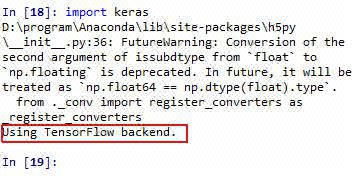

这里可以看到我的Keras的底层是基于TensorFlow的

## 2.常规LSTM时间序列分析

LSTM（Long Short-Term Memory），长短期记忆模型的核心是细胞的状态及其中的门结构。$^{[1]}$  

LSTM的细胞状态由两种激活函数构成（sigmoid和tanh），分别组成遗忘门、输入门和输出门。
其中，sigmoid将输入的参数输出为0到1之间的数值，它主要用于判定某特征对于模型的影响程度，为1时影响程度最大。如下图

tanh将输入的参数输出为-1到1之间的数值，用于将结果进行归一标准化，避免因为特征维度差异造成不必要的权重影响。如下图

最后，我们可以得到一个神经网络单元的结构如下，不熟悉的话可以自己手画一下，强化记忆。其中$C_n$代表单元的长期记忆，$h_n$代表单元的短期记忆，$x_n$为每次外部输入的数据

可见，长期记忆$C_n$在经过每个单元时，要删减掉一些不重要的信息，随后增加一些重要信息。  
而短期记忆的结果，一般作为最终的预测结果，是$C_n$,$h_n-1$,$x_n-1$共同作用的结果。  

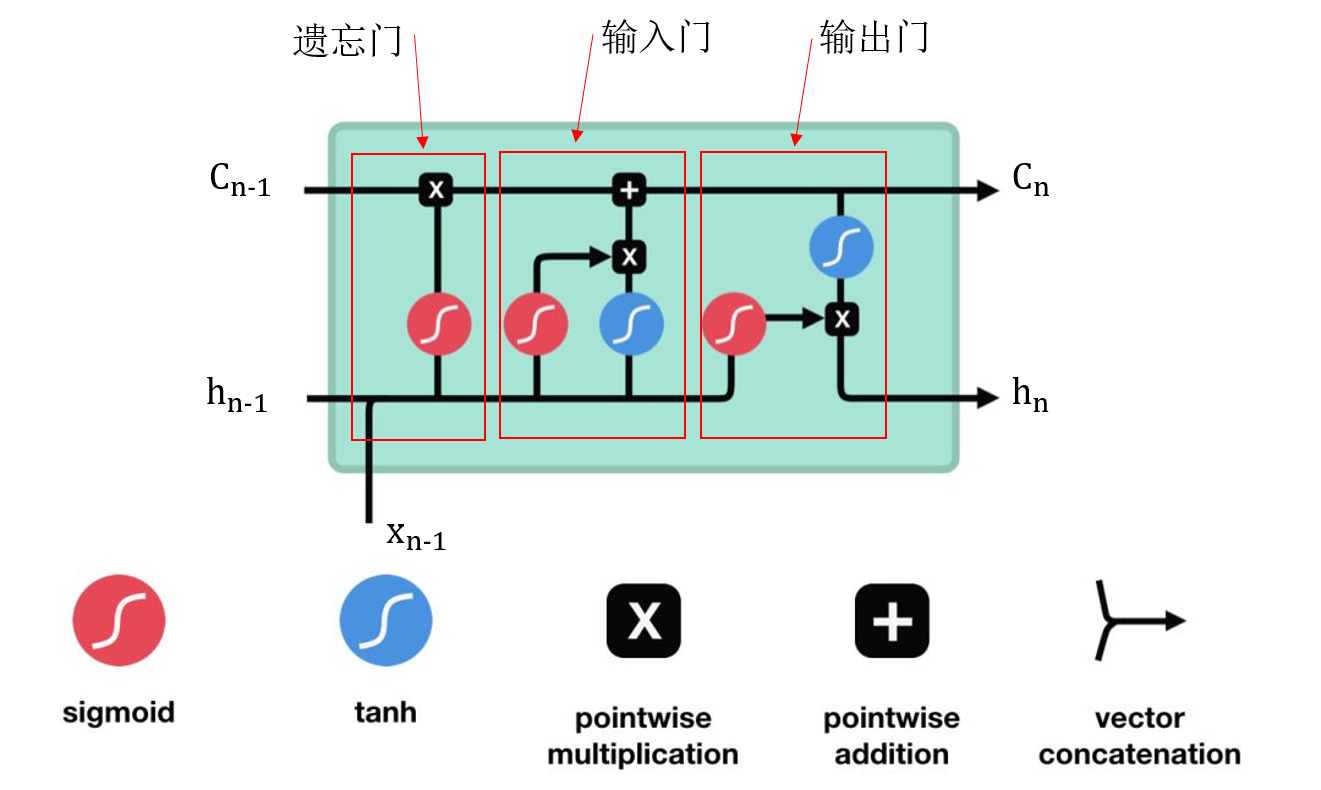

### 2.1仓库发货量预测

接下来，我们以某仓库过去一段时间的发货量来预测未来发货量，说明一下Keras中LSTM时间序列问题的一般建模流程

导入必要的数据分析，可视化模块

In [2]:
import time
import warnings
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import newaxis
import pandas as pd

In [3]:
df = pd.read_csv(r'E://working_projects//vehicle_type_recognition//LSTM//009.csv',engine='python')

数据有631条

In [4]:
df.shape

(631, 1)

进一步，我们可以看到数据的结构是一列发货量的数据

In [5]:
df.head(10)

27691
0  27036
1  26522
2  27361
3  27369
4  26835
5  29612
6  30057
7  27479
8  30403
9  30529

从图像来看发货量结果并不是很平滑，如果要用Arima算法的话，需要多次平滑才能预测。所以，我们还是用LSTM模型

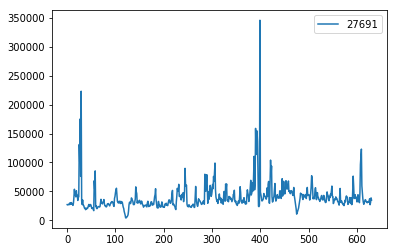

In [6]:
df.plot()

###  2.2处理数据

In [7]:
#划分训练集、测试集
def load_data(filename, seq_len, normalise_window):
    
    data = open(filename, 'rb').readlines()

    sequence_length = seq_len + 2
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])  #得到长度为seq_len+1的向量，最后一个作为label

# 记录normalise_windows归一化前，x_test中window[0]值
    re = np.array(result).astype('float32')
    # print('re is:',re)
    ro = int(round(0.9 * len(result)))  #划分训练集和测试集
    # print('ro is:',ro)
    window = re[ro:, :1]
    # print('window is:',window)
    # normalise_windows归一化
    if normalise_window:
        result = normalise_windows(result) #以最初日期的数据进行初始化
    #print('result is:',result)
    result = np.array(result)
    
    #划分train、test
    row = round(0.9 * result.shape[0])
    row = int(row)

    train = result[:row, :]

    
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1:]
    x_test = result[row:, :-1]
    y_test = result[row:, -1:]
    
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return [x_train, y_train, x_test, y_test,window] #window是最终的测试结果的真实值

In [8]:
#将输入结果进行归一化
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:   #window shape (sequence_length L ,)  即(51L,)
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

#将预测的结果进行反归一化，获得真实预测结果
def FNormalise_windows(window,data):
    normalised_data = []
    for i in range(len(window)):   #window shape (sequence_length L ,)  即(51L,)
        normalised_data.append((float(data[i]) + 1 ) * float(window[i]))
    return normalised_data

In [9]:
#直接全部预测
def predict_point_by_point(model, data):
    predicted = model.predict(data)
    print('predicted shape:',np.array(predicted).shape)  #(412L,1L)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

这里首先我们要依据给定的数据进行9:1的比例划分训练集（522条）和测试集（58条），并预留51条数据用作验证集。  
另外，通过对数据的观察我们发现当前数据的量级过大，为了获得更好的结果，我们构建函数对数据进行归一化处理。  
处理的详情见代码

In [10]:
X_train, y_train, X_test, y_test, window = load_data('E://working_projects//vehicle_type_recognition//LSTM//009.csv', 50, True)

构建数据集后，进一步我们确认下数据集的size

In [11]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)  
print('y_test shape:',y_test.shape)  

X_train shape: (522, 51, 1)
y_train shape: (522, 1)
X_test shape: (58, 51, 1)
y_test shape: (58, 1)


In [13]:
type(X_train)

numpy.ndarray

In [15]:
y_train

array([[-5.60818866e-01],
       [ 5.68946137e-01],
       [ 4.60503326e-01],
       [-1.84002851e-01],
       [-2.12090822e-01],
       [-1.65344043e-01],
       [-3.24511250e-01],
       [-4.59608169e-01],
       [-4.79497244e-01],
       [ 3.28866077e-02],
       [-2.74088697e-01],
       [-8.94232449e-01],
       [ 5.64018297e-02],
       [-2.84485716e-01],
       [-5.46435994e-01],
       [-5.95537439e-02],
       [-2.40080638e-01],
       [-4.88429326e-01],
       [ 9.95475271e+00],
       [-4.73369705e-01],
       [ 1.04925946e-01],
       [-8.13208191e-01],
       [ 9.86192529e-01],
       [ 5.42171603e-01],
       [ 6.39931657e+00],
       [ 3.14880564e+00],
       [-6.78717242e-02],
       [-5.19600010e-02],
       [-7.36023561e-02],
       [ 3.33364361e-01],
       [ 1.18309576e-01],
       [ 1.59307768e-01],
       [-3.02755224e-01],
       [ 4.82096635e-02],
       [ 8.39859230e-01],
       [ 6.18201712e-02],
       [-3.20562055e-01],
       [ 6.96358028e-01],
       [ 1.6

In [14]:
type(y_train)

numpy.ndarray

###  2.3构建模型

在获得处理好数据集后，构建LSTM神经网络模型进行结果预测

首先，导入神经网络的方法。  

In [11]:
from keras.models import Sequential
from keras.layers import Bidirectional,LSTM
from keras.layers.core import Dense, Activation, Dropout

D:\program\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


其中，Sequential用于构建序贯模型，它可以由多个网络层进行线性堆叠。  
Bidirectional是双向神经网络结构，Dense就是我们所说的一层全连接神经网络，activation是激活函数，dropout是选择层后连接的神经元数，以避免过拟合。  
参考链接：https://keras-cn.readthedocs.io/en/latest/getting_started/sequential_model/

### 双向神经网络

#创建神经网络
Model = Sequential()

#增加中间层结构,第一层
Model.add(Bidirectional(LSTM(50,return_sequences = True),input_shape = (None,1)))
Model.add(Dropout(0.2))

#第二层
Model.add(Bidirectional(LSTM(50,return_sequences = True),input_shape = (None,50)))
#Model.add(LSTM(input_shape = (None,50),units = 50,return_sequences = True))
Model.add(Dropout(0.2))

#第三层
Model.add(Bidirectional(LSTM(50,return_sequences = True),input_shape = (None,50)))
Model.add(Dropout(0.2))

#第四层
Model.add(Bidirectional(LSTM(50,return_sequences=False)))
#Model.add(LSTM(50,return_sequences=False))
Model.add(Dropout(0.2))

#第五层
Model.add(Dense(units=1))
Model.add(Activation("linear"))

Model.compile(loss="mse", optimizer="rmsprop")

### 单向神经网络

低版本的keras中模型构建的方式采用参数input_dim和output_dim,在高版本中采用此用法会出现红色的warning。  
因此，在高版本中采用input_shape和units，代替原来的input_dim和output_dim，以避免红色的warning信息。  
两种参数构建模型的效果是一样的，在此说明。

model = Sequential() #layers [1,50,50,50,50,1]

model.add(LSTM(input_dim=1,output_dim=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(input_dim=50,output_dim=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(input_dim=50,output_dim=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation("linear"))

start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print("Compilation Time : ", time.time() - start)

In [12]:
model = Sequential() #layers [1,50,50,50,50,1]

model.add(LSTM(input_shape=(None,1),units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(input_shape=(None,50),units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(input_shape=(None,50),units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation("linear"))
# model.add(Activation("sigmoid"))

start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.025931358337402344


In [13]:
#查看当前模型中神经网络层数
len(model.layers)

10

In [14]:
#查看模型的结构
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
__________

随后，对结果进行拟合  
其中batch_size是每次梯度更新的样本数，未写明则为32；  
epochs是指训练模型迭代次数；  
validation_split代表将数据集中多少数据用作验证集的训练数据的比例。  
fit中的相关参数可参考：https://keras.io/zh/models/model/#fit

在测试模式下返回模型的误差值和评估标准值。

In [15]:
model.fit(X_train,y_train,batch_size=10,nb_epoch=100,validation_split=0.05)

D:\program\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 495 samples, validate on 27 samples
Epoch 1/100
495/495 [==============================] - 7s 14ms/step - loss: 0.6048 - val_loss: 0.5663
Epoch 2/100
495/495 [==============================] - 4s 8ms/step - loss: 0.5292 - val_loss: 0.7025
Epoch 3/100
495/495 [==============================] - 4s 8ms/step - loss: 0.4878 - val_loss: 0.0874
Epoch 4/100
495/495 [==============================] - 4s 8ms/step - loss: 0.4681 - val_loss: 0.0829
Epoch 5/100
495/495 [==============================] - 4s 8ms/step - loss: 0.4502 - val_loss: 0.1231
Epoch 6/100
495/495 [==============================] - 4s 8ms/step - loss: 0.4276 - val_loss: 0.1287
Epoch 7/100
495/495 [==============================] - 4s 8ms/step - loss: 0.4334 - val_loss: 0.1020
Epoch 8/100
495/495 [==============================] - 4s 8ms/step - loss: 0.4293 - val_loss: 0.0891
Epoch 9/100
495/495 [==============================] - 4s 8ms/step - loss: 0.4141 - val_loss: 0.1065
Epoch 10/100
495/495 [=======================

Epoch 81/100
495/495 [==============================] - 4s 7ms/step - loss: 0.3027 - val_loss: 0.0359
Epoch 82/100
495/495 [==============================] - 4s 8ms/step - loss: 0.2995 - val_loss: 0.0771
Epoch 83/100
495/495 [==============================] - 4s 8ms/step - loss: 0.2929 - val_loss: 0.0414
Epoch 84/100
495/495 [==============================] - 4s 8ms/step - loss: 0.2831 - val_loss: 0.0390
Epoch 85/100
495/495 [==============================] - 4s 8ms/step - loss: 0.2741 - val_loss: 0.0480
Epoch 86/100
495/495 [==============================] - 4s 7ms/step - loss: 0.2729 - val_loss: 0.0351
Epoch 87/100
495/495 [==============================] - 4s 8ms/step - loss: 0.2767 - val_loss: 0.1388
Epoch 88/100
495/495 [==============================] - 4s 8ms/step - loss: 0.2375 - val_loss: 0.0415
Epoch 89/100
495/495 [==============================] - 4s 8ms/step - loss: 0.3049 - val_loss: 0.0678
Epoch 90/100
495/495 [==============================] - 4s 8ms/step - loss: 0.2514

In [16]:
score2 = model.evaluate(X_test,y_test)

58/58 [==============================] - 0s 1ms/step


In [17]:
print(score2)

0.12872567772865295


随后，对所有的测试结果进行预测，并重塑预测结果的输出size。  
显然这里的预测结果是我们在上面流程中已经标准化后的结果，因此这里我们需要将预测结果进一步反归一化后得到最终的预测结果

In [18]:
point_by_point_predictions = predict_point_by_point(model, X_test)

predicted shape: (58, 1)


In [19]:
point_by_point_predictions = FNormalise_windows(window,point_by_point_predictions)

In [20]:
point_by_point_predictions

[31017.722208827734,
 31451.113379508257,
 28931.401636600494,
 32456.85795393586,
 36548.08085516095,
 33928.83669912815,
 40520.62545058131,
 41546.39201812446,
 39573.98421634734,
 40095.02783207595,
 30183.932276070118,
 33021.69595807791,
 36208.1581376493,
 35202.218674078584,
 40400.78002423048,
 32302.97497576475,
 31424.089402914047,
 41001.724046468735,
 30360.716313242912,
 32370.45769754052,
 49472.2049947083,
 64725.27766895294,
 54176.59723633528,
 35116.96418821812,
 41761.66843363643,
 48359.247944012284,
 43016.63314113021,
 43726.8236618042,
 39773.4048704803,
 35443.373977422714,
 45080.88133281469,
 46214.134998083115,
 36980.62579870224,
 36197.97526860237,
 34667.782169640064,
 50059.133137106895,
 76524.86625480652,
 88161.08126282692,
 97845.43533325195,
 47972.156582951546,
 36035.95656836033,
 34617.236468434334,
 54982.33409500122,
 39699.06143525243,
 39575.10747885704,
 38526.80720585585,
 40346.18024158478,
 39702.44975358248,
 39025.37908267975,
 38289.50

同样，我们可以对测试结果进行反归一化。

In [21]:
y_test = FNormalise_windows(window,y_test)

In [22]:
def plot_results(predicted_data, true_data, filename):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
    plt.savefig(filename+'.png')

我们把真实结果和预测结果进行可视化分析，可见预测与真实结果的趋势比较接近，但是峰值位置略有滞后

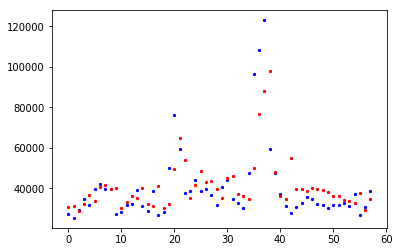

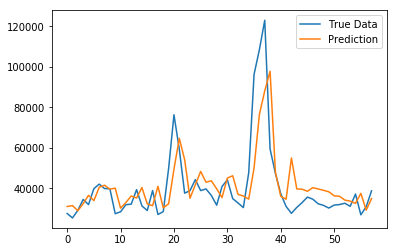

<Figure size 432x288 with 0 Axes>

In [23]:
plt.scatter(range(len(point_by_point_predictions)),y_test,color='b',s = 5)
plt.scatter(range(len(point_by_point_predictions)), point_by_point_predictions,s = 5,color='r', marker='o')
plot_results(point_by_point_predictions,y_test,'point_by_point_predictions')

紧接着，我们可以统计下预测结果和真实结果的误差，在所有的数据中，我们认为如果误差和真实结果的误差在20%以内，则认为预测准确

## 3.思考

另外，LSTM在预测方面还有可能涉及到多变量预测的结果。  
这一方面是指多个维度的预测特征，这时候其实是把LSTM时间序列问题转化成了一个监督学习的问题。  
另一方面是预测多个特征的问题，例如预测未来一周每天的发货量。这种情况可以改变模型的结构，或者将每次的预测结果归入输入，预测第二天的结果等等。有时间再写一下。  

参考文献：
[1] :难以置信！LSTM和GRU的解析从未如此清晰(https://blog.csdn.net/dQCFKyQDXYm3F8rB0/article/details/82922386) 